In [112]:
#Importing the essential libraries
from statsmodels.tsa.seasonal import STL
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import pearsonr
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
register_matplotlib_converters()
from time import time
from statsmodels.tsa.stattools import adfuller,kpss
import warnings
warnings.filterwarnings('ignore')

In [28]:
df = pd.read_csv('ice_cream.csv')
df.columns

Index(['DATE', 'IPN31152N'], dtype='object')

In [24]:
def plot_time_series(series, title='Ice Cream Search', ylabel='Value', xlabel='Date', figsize=(12, 6), color='blue'):
    """
    Plots a time series with date index.

    Parameters:
        series (pd.Series): Pandas Series with datetime index.
        title (str): Title of the plot.
        ylabel (str): Y-axis label.
        xlabel (str): X-axis label.
        figsize (tuple): Size of the figure.
        color (str): Line color.
    """
    plt.figure(figsize=figsize)
    plt.plot(series, color=color, linewidth=2)
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

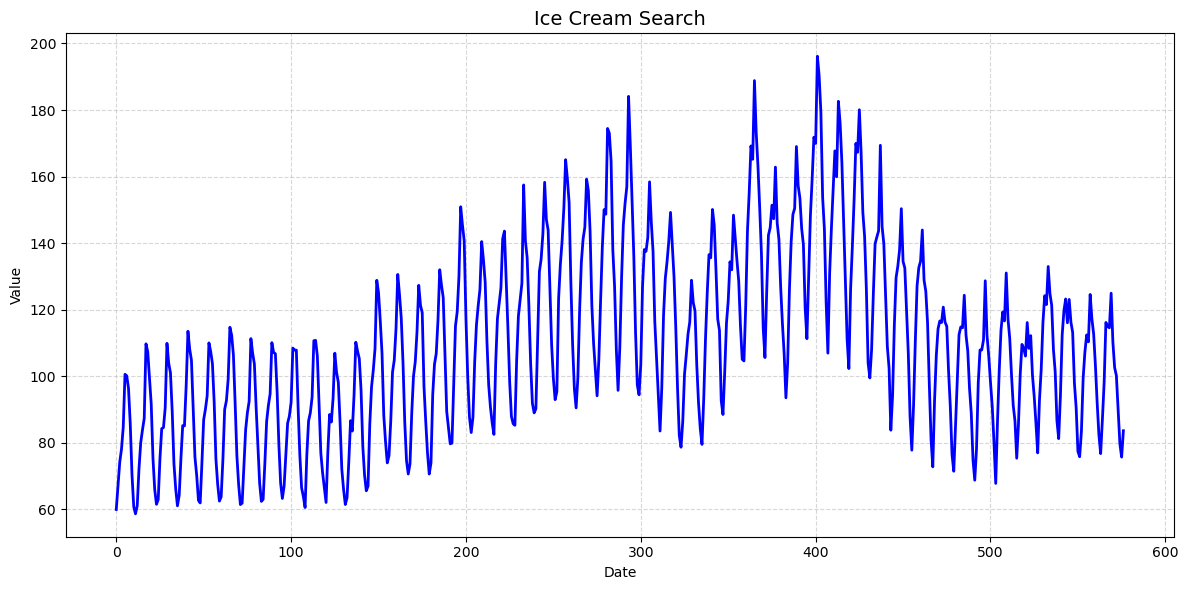

In [30]:
plot_time_series(df['IPN31152N'])

In [36]:
# STL decomposition using LOESS
stl = STL(df['IPN31152N'],period = 12)
res = stl.fit()

In [38]:
seas, trend, resd = res.seasonal, res.trend, res.resid

In [40]:
def plot_stl_components(seasonal, trend, resid, original=None, title='STL Decomposition'):
    """
    Plots seasonal, trend, and residual components from STL decomposition.

    Args:
        seasonal (pd.Series): Seasonal component.
        trend (pd.Series): Trend component.
        resid (pd.Series): Residual component.
        original (pd.Series, optional): Original time series to plot as reference.
        title (str): Plot title.
    """
    plt.figure(figsize=(8, 6))

    if original is not None:
        plt.subplot(4, 1, 1)
        plt.plot(original, label='Original', color='black')
        plt.title(f'{title} - Original')
        plt.grid(True)

    plt.subplot(4, 1, 2 if original is not None else 1)
    plt.plot(seasonal, label='Seasonal', color='blue')
    plt.title('Seasonal Component')
    plt.grid(True)

    plt.subplot(4, 1, 3 if original is not None else 2)
    plt.plot(trend, label='Trend', color='green')
    plt.title('Trend Component')
    plt.grid(True)

    plt.subplot(4, 1, 4 if original is not None else 3)
    plt.plot(resid, label='Residual', color='red')
    plt.title('Residual Component')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

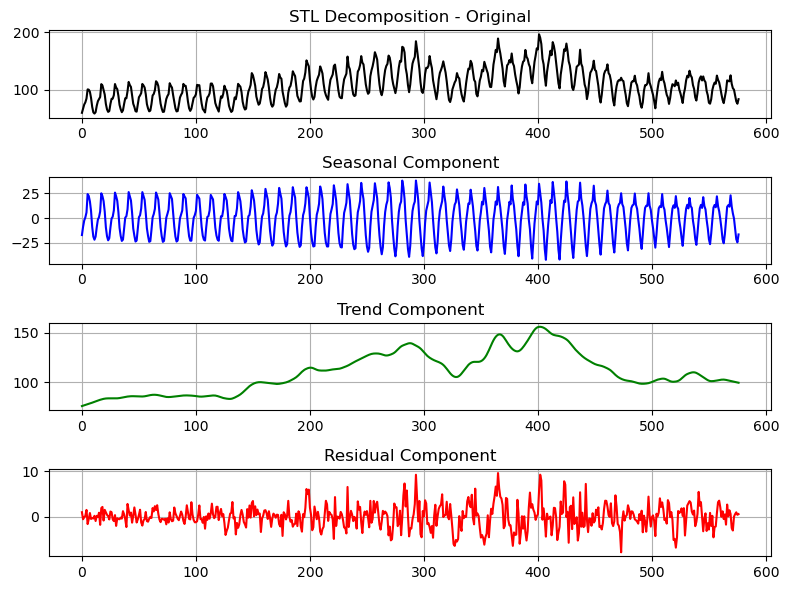

In [46]:
plot_stl_components(seas,trend,resd,original = df['IPN31152N'])

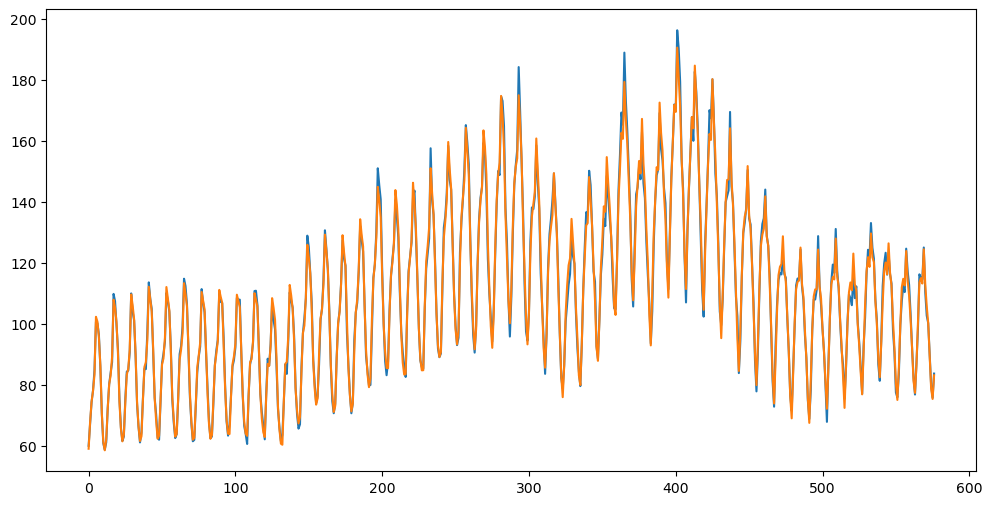

In [54]:
estimate = trend + seas
plt.figure(figsize = (12,6))
plt.plot(df['IPN31152N'])
plt.plot(estimate)

# Anomaly Detection


In [64]:
resid_mu = resd.mean()
resid_std = resd.std()

In [68]:
lower = resid_mu - 3*resid_std
upper = resid_mu + 3*resid_std

In [72]:
df.tail()

,DATE,IPN31152N
572,2019-09-01,100.1741
573,2019-10-01,90.1684
574,2019-11-01,79.7223
575,2019-12-01,75.7094
576,2020-01-01,83.6290


In [100]:
residuals = resd.to_frame(name = 'residuals')
residuals

,residuals
0,0.974651
1,-0.576589
2,-0.144870
3,0.171929
4,1.480308
...,...
572,-0.012088
573,0.566495
574,0.952217
575,0.404080


In [106]:
residuals['lower'] = lower
residuals['upper'] = upper

In [116]:
residuals

,residuals,lower,upper
0,0.974651,-7.648409,7.666959
1,-0.576589,-7.648409,7.666959
2,-0.144870,-7.648409,7.666959
3,0.171929,-7.648409,7.666959
4,1.480308,-7.648409,7.666959
...,...,...,...
572,-0.012088,-7.648409,7.666959
573,0.566495,-7.648409,7.666959
574,0.952217,-7.648409,7.666959
575,0.404080,-7.648409,7.666959


In [130]:
residuals['anomaly'] = np.where((residuals['residuals'] >= residuals['lower']) & (residuals['residuals'] <= residuals['upper']),0,1)

In [132]:
residuals['anomaly'].value_counts()

anomaly
0    571
1      6
Name: count, dtype: int64

In [135]:
residuals

,residuals,lower,upper,anomaly
0,0.974651,-7.648409,7.666959,0
1,-0.576589,-7.648409,7.666959,0
2,-0.144870,-7.648409,7.666959,0
3,0.171929,-7.648409,7.666959,0
4,1.480308,-7.648409,7.666959,0
...,...,...,...,...
572,-0.012088,-7.648409,7.666959,0
573,0.566495,-7.648409,7.666959,0
574,0.952217,-7.648409,7.666959,0
575,0.404080,-7.648409,7.666959,0


In [149]:
def plot_residuals_with_anomalies(df):
    """
    Plots residuals and highlights anomalies (where anomaly == 1) in red.
    
    Args:
        df (pd.DataFrame): Must contain 'residuals' and 'anomaly' columns.
    """
    #print the anomalies and their values along with upper and lower bound of residuals
    print(df[df['anomaly']==1])
    
    plt.figure(figsize=(12, 6))

    # Plot residuals
    plt.plot(df.index, df['residuals'], label='Residuals', color='blue')

    # Highlight anomalies
    anomalies = df[df['anomaly'] == 1]
    plt.scatter(anomalies.index, anomalies['residuals'], color='red', label='Anomalies', zorder=3)

    # Optional: Plot upper/lower bounds if available
    if 'upper' in df.columns and 'lower' in df.columns:
        plt.plot(df.index, df['upper'], linestyle='--', color='gray', alpha=0.5, label='Upper Bound')
        plt.plot(df.index, df['lower'], linestyle='--', color='gray', alpha=0.5, label='Lower Bound')

    plt.title('Residuals with Anomalies Highlighted')
    plt.xlabel('Index')
    plt.ylabel('Residual')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

     residuals     lower     upper  anomaly
293   9.236386 -7.648409  7.666959        1
365   9.607307 -7.648409  7.666959        1
402   9.240192 -7.648409  7.666959        1
403   7.988302 -7.648409  7.666959        1
423   7.802831 -7.648409  7.666959        1
473  -7.865105 -7.648409  7.666959        1


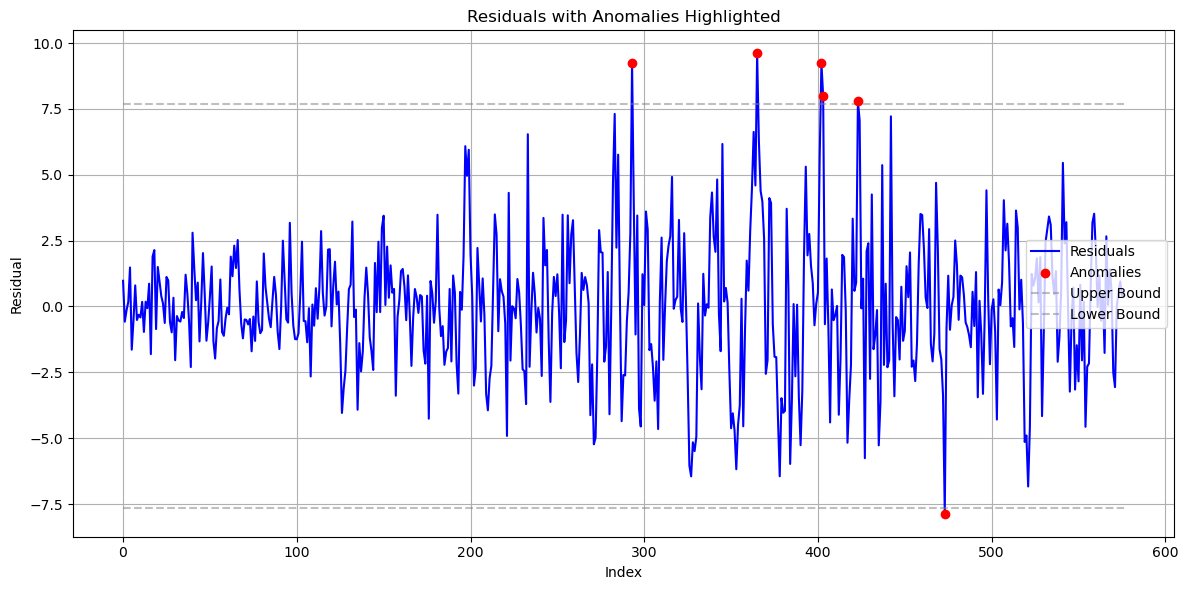

In [151]:
plot_residuals_with_anomalies(residuals)